# Оценка риска ДТП

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.
Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика: 

1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
- Для модели выбрать тип виновника — только машина (car).
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
- Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы.

**Краткое описание таблиц:**

**collisions** — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

**parties** — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

**vehicles** — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Подключение к базе данных. Загрузка таблиц SQL.

### Установка программных пакетов и импорт необходимых библиотек.

In [1]:
#устанавливаем профайлер
!pip install ydata_profiling --quiet

In [2]:
!pip install category_encoders --quiet

In [3]:
!pip install --upgrade catboost --quiet

In [4]:
import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sqlalchemy import create_engine 

from ydata_profiling import ProfileReport

from lightgbm import LGBMClassifier

from numpy.random import RandomState
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, precision_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle


import category_encoders as ce

from catboost import CatBoostClassifier, Pool

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

SEED = 42
random.seed(SEED)                
np.random.seed(SEED)            
torch.manual_seed(SEED)          
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False     

### Создание конфигурации для подключения к базе данных `data-science-vehicle-db`.

In [5]:
db_config = {
'user': '_____________', # имя пользователя,
'pwd': '_________________', # пароль,
'host': '_______________________',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

### Создание подключения.

In [6]:
engine = create_engine(connection_string) 

### Проверка подключения путем пробного запроса к одной из таблиц.

In [7]:
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [8]:
sample_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


Подключение выполнено корректно.

## Проведение первичного исследования таблиц

### Сохраняем таблицу collisions в отдельном датасете и выводим информацию о ней методом .info()

In [9]:
query = '''
SELECT *
FROM collisions;
'''

collisions = pd.read_sql_query(query, con=engine) 

In [10]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [11]:
display(collisions.head())

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


### Сохраняем таблицу parties в отдельном датасете и выводим информацию о ней методом .info()

In [12]:
query = '''
SELECT *
FROM parties;
'''

parties = pd.read_sql_query(query, con=engine) 

In [13]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


### Сохраняем таблицу vehicles в отдельном датасете и выводим информацию о ней методом .info()

In [14]:
query = '''
SELECT *
FROM vehicles;
'''

vehicles = pd.read_sql_query(query, con=engine) 

In [15]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


### Выводы по итогам первичного исследования таблиц:

- Все таблицы имеют описанный в проекте набор данных.
- Количество таблиц соответствует условию задачи.
- Имеется общий ключ для связи таблиц.

##  Проведение статистического анализа факторов ДТП

### Выясняем в какие месяцы происходило наибольшее количество аварий.

#### Оформляем запрос.

In [16]:
query = '''
SELECT TO_CHAR(DATE_TRUNC('month', collision_date), 'Month') AS month,
       COUNT(case_id) AS cases_number
FROM collisions
GROUP BY month;
'''

months_reply = pd.read_sql_query(query, con=engine) 

#### Строим график.

<Figure size 720x432 with 0 Axes>

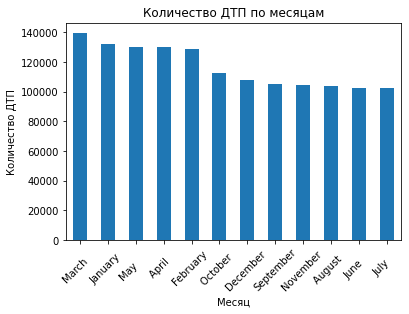

In [17]:
# Сортируем данные по количеству случаев в убывающем порядке
months_reply = months_reply.sort_values('cases_number', ascending=False)

# Построение гистограммы по месяцам
plt.figure(figsize=(10, 6))  # Размер гистограммы

# Используем функцию plot из pandas DataFrame для построения гистограммы
months_reply.plot(x='month', y='cases_number', kind='bar', legend=None)

# Настройка осей и заголовка гистограммы
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.title('Количество ДТП по месяцам')

plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости

plt.show();  # Отображение гистограммы

#### Делаем выводы:

- Весной и зимой аварии случаются гораздо чаще, чем летом и осенью.
- Наиболее часто аварии случались в марте, январе и мае.

### Список аналитических задач для проработки коллегами.

#### Список задач:

- Выяснить в какое время суток чаще всего происходят ДТП. Для решения задачи необходимо предварительно категоризировать время ДТП.
- Выяснить к какой возрастной категории относится автомобиль виновника ДТП? Для решения задачи необходимо предварительно категоризировать возраст авто.
- Провести анализ зависимости серьёзности повреждений транспортного средства от состояния виновника ДТП. 
- Выяснить какие нарушения чаще всего приводят к возникновению ДТП.
- Выяснить в какую погоду чаще всего происходят ДТП.
- Выяснить при каком освещении чаще всего происходят ДТП.

### Решение задачи №2 из списка.

#### Оформляем запрос.

In [18]:
query = '''
WITH age_categories AS (
  SELECT
    CASE
      WHEN vehicles.VEHICLE_AGE BETWEEN 0 AND 3 THEN 'Новый автомобиль'
      WHEN vehicles.VEHICLE_AGE BETWEEN 4 AND 6 THEN 'Молодой автомобиль'
      WHEN vehicles.VEHICLE_AGE BETWEEN 7 AND 10 THEN 'Средний автомобиль'
      WHEN vehicles.VEHICLE_AGE BETWEEN 11 AND 15 THEN 'Старый автомобиль'
      ELSE 'Очень старый автомобиль'
    END AS age_category,
    parties.CASE_ID,
    parties.PARTY_NUMBER
  FROM
    vehicles
  JOIN
    parties ON vehicles.CASE_ID = parties.CASE_ID AND vehicles.PARTY_NUMBER = parties.PARTY_NUMBER
  WHERE
    parties.AT_FAULT = 1
)

SELECT
  age_categories.age_category,
  COUNT(collisions.CASE_ID) AS case_count
FROM
  collisions
JOIN
  age_categories ON collisions.CASE_ID = age_categories.CASE_ID
GROUP BY
  age_categories.age_category
ORDER BY
  MIN(collisions.CASE_ID);
'''

fault_car_query = pd.read_sql_query(query, con=engine)

#### Строим гистограмму.

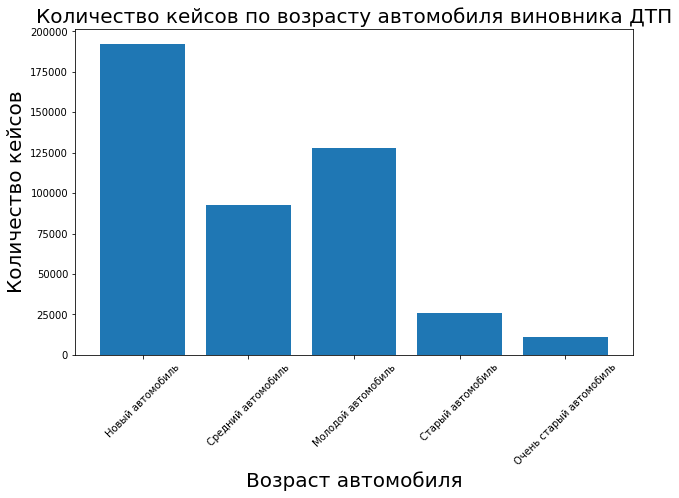

In [19]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(fault_car_query['age_category'], fault_car_query['case_count'])
plt.xlabel('Возраст автомобиля', fontsize=20)  # Увеличиваем название оси X
plt.ylabel('Количество кейсов', fontsize=20)   # Увеличиваем название оси Y
plt.title('Количество кейсов по возрасту автомобиля виновника ДТП', fontsize=20)
plt.xticks(rotation=45)

plt.show()

#### Выводы:

- Чаще всего у виновника ДТП возраст авто не превышает 3 лет.
- Крайне редко возраст авто виновника ДТП превышает 10 лет.

### Решение задачи №3 из списка.

#### Оформляем запрос.

In [20]:
query = '''
WITH at_fault_parties AS (
  SELECT CASE_ID, 
         PARTY_DRUG_PHYSICAL
  FROM parties
  WHERE AT_FAULT = 1
),

collision_damage AS (
  SELECT CASE_ID, 
         COLLISION_DAMAGE
  FROM collisions
)

SELECT at_fault_parties.PARTY_DRUG_PHYSICAL, 
       collision_damage.COLLISION_DAMAGE, 
       COUNT(*) AS case_count
FROM at_fault_parties
JOIN collision_damage ON at_fault_parties.CASE_ID = collision_damage.CASE_ID
GROUP BY at_fault_parties.PARTY_DRUG_PHYSICAL, collision_damage.COLLISION_DAMAGE;
'''

collision_state_query = pd.read_sql_query(query, con=engine)

#### Строим heatmap.

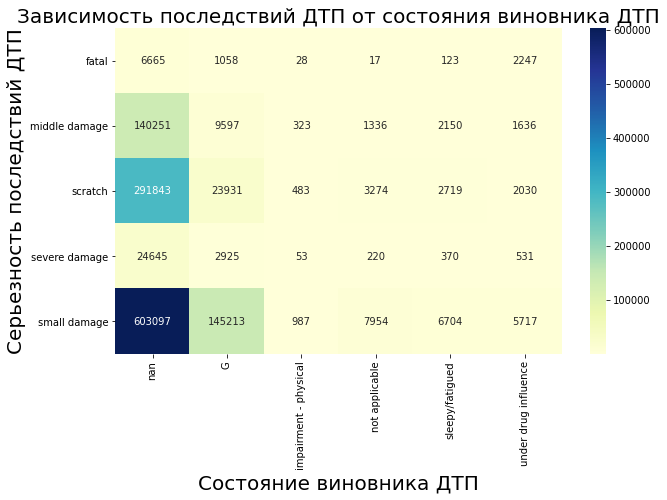

In [21]:
# Построение диаграммы с квадратами
plt.figure(figsize=(10, 6))
sns.heatmap(collision_state_query.pivot('collision_damage', 'party_drug_physical', 'case_count'), 
            annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Состояние виновника ДТП', fontsize=20)
plt.ylabel('Серьезность последствий ДТП', fontsize=20)
plt.title('Зависимость последствий ДТП от состояния виновника ДТП', fontsize=20)
plt.show()

#### Выводы:

- В подавляющем большинстве кейсов данные о состоянии водителя либо не указаны вовсе либо состояние водителя не известно.
- Водители под воздействием лекарств гораздо чаще являются виновниками **ДТП с наиболее серьезными последствиями** в сравнении с уставшими водителями.
- Уставшие водители чаще являются виновниками **ДТП со средними или небольшими последствиями (категории middle damage и small damage)** в сравнении с водителями под воздействием лекарств.
- Водители с ухудшением состояния, не связанным с усталосью или приемом лекарств, гораздо реже становятся виновниками ДТП в сравнении с уставшими водителями и водителями под воздействием лекарств.

## Создание модели для оценки водительского риска

### Предобработка данных.

#### Выгрузка данных из таблиц с указанными в проекте фильтрами.

In [22]:
query = '''
SELECT 
    c.*, 
    p.PARTY_NUMBER, 
    p.PARTY_TYPE, 
    p.AT_FAULT, 
    p.INSURANCE_PREMIUM, 
    p.PARTY_DRUG_PHYSICAL, 
    p.PARTY_SOBRIETY, 
    p.CELLPHONE_IN_USE, 
    v.VEHICLE_TYPE, 
    v.VEHICLE_TRANSMISSION, 
    v.VEHICLE_AGE
FROM 
    collisions c
JOIN 
    parties p ON c.CASE_ID = p.CASE_ID
JOIN 
    vehicles v ON c.CASE_ID = v.CASE_ID AND p.PARTY_NUMBER = v.PARTY_NUMBER
WHERE 
    p.PARTY_TYPE = 'car' 
    AND c.COLLISION_DAMAGE <> 'scratch' 
    AND EXTRACT(YEAR FROM c.COLLISION_DATE) = 2012;
'''

data = pd.read_sql_query(query, con=engine)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      56248 non-null  object 
 1   county_city_location         56248 non-null  object 
 2   county_location              56248 non-null  object 
 3   distance                     56248 non-null  float64
 4   direction                    43230 non-null  object 
 5   intersection                 56073 non-null  float64
 6   weather_1                    56080 non-null  object 
 7   location_type                25932 non-null  object 
 8   collision_damage             56248 non-null  object 
 9   party_count                  56248 non-null  int64  
 10  primary_collision_factor     56137 non-null  object 
 11  pcf_violation_category       55482 non-null  object 
 12  type_of_collision            55940 non-null  object 
 13  motor_vehicle_in

In [24]:
initial_data = data.copy()

**Предварительные выводы:**
- данные содержат пропуски;
- данные содержат избыточную информацию, которая не относится к признакам;
- некоторые данные необходимо категоризировать, закодировать и масшатбировать до перехода к машинному обучению.

#### Проводим первичный отбор факторов, необходимых для модели:

- case_id (номер ДТП в базе данных) - не является признаком или фактором ДТП, **исключаем**;
- county_city_location (номер географических районов, где произошло ДТП) - не является фактором ДТП, **исключаем**;
- county_location (названия географических районов, где произошло ДТП) - не является фактором ДТП, **исключаем**;
- distance (расстояние от главной дороги (метры)) - описание этого столбца не до конца понятно, но полагаю, что не является фактором ДТП, **исключаем**;
- direction (направление движения) - не является фактором ДТП, **исключаем**;
- intersection (является ли место происшествия перекрёстком) - относится к результату ДТП, а не к фактору ДТП, **исключаем**;
- weather_1 погода - является фактором ДТП, **оставляем**;
- location_type (тип дороги) - может являться фактором ДТП, пока **оставляем**;
- collision_damage (серьёзность происшествия) - относится к результату ДТП, а не к фактору ДТП, **исключаем**;
- party_count (количество участников ДТП) - относится к результату ДТП, а не к фактору ДТП, **исключаем**;
- primary_collision_factor (основной фактор аварии) - значения, указанные в этом столбце, не позволяют предсказать ДТП до поездки, **исключаем**;
- pcf_violation_category (категория нарушения) - юридическая квалификация ДТП, не фактор ДТП, **исключаем**;
- type_of_collision (тип аварии) - относится к результату ДТП, а не к фактору ДТП, **исключаем**; 
- motor_vehicle_involved_with (дополнительные участники ДТП) - относится к результату ДТП, а не к фактору ДТП, **исключаем**; 
- road_surface (состояние дороги) - является фактором ДТП, **оставляем**;
- road_condition_1 (дорожное состояние) - является фактором ДТП, **оставляем**;
- lighting (освещение) - является фактором ДТП, **оставляем**;
- control_device (устройство управления) - описание этого столбца не до конца понятно, но полагаю, что не является фактором ДТП, **исключаем**;
- collision_date (дата происшествия) - может являться фактором ДТП, пока **оставляем**;
- collision_time (время происшествия) - может являться фактором ДТП, пока **оставляем**;
- party_number (номер участника происшествия) - не является признаком или фактором ДТП, **исключаем**;
- party_type (тип участника происшествия) - не является признаком или фактором ДТП, **исключаем**;
- at_fault (виновность участника) - целевая переменная, **оставляем**;
- insurance_premium (сумма страховки (тыс. долларов)) - описание этого столбца не до конца понятно, но полагаю, что не является фактором ДТП, **исключаем**;
- party_drug_physical (состояние участника) - является фактором ДТП, **оставляем**;
- party_sobriety (трезвость участника) - является фактором ДТП, **оставляем**;
- cellphone_in_use (наличие громкой связи) - является фактором ДТП, **оставляем**;
- vehicle_type (тип кузова) - может являться фактором ДТП, пока **оставляем**;
- vehicle_transmission (тип КПП) - может являться фактором ДТП, пока **оставляем**;
- vehicle_age (возраст автомобиля (в годах)) - заказчик указал одним из требований учет этого фактора, **оставляем**.

#### Удаляем лишние столбцы.

In [25]:
# Список столбцов для удаления
columns_to_drop = ["case_id", "county_city_location", "county_location", "direction", "intersection", 
                   "collision_damage", "party_count", "primary_collision_factor", "pcf_violation_category", 
                   "type_of_collision", "motor_vehicle_involved_with", "party_number", "party_type", "distance", 
                   "insurance_premium", "control_device"]

# Удаляем столбцы
data = data.drop(columns=columns_to_drop)

#### Корректируем названия столбцов.

In [26]:
# Удаляем "_1" из названий столбцов
data.columns = [col.replace("_1", "") for col in data.columns]

#### Избавляемся от пропусков.

##### Выводим информацию о проценте пропусков в каждом столбце:

In [27]:
# Выводим информацию о проценте пропусков в каждом столбце
missing_data = data.isnull().sum() / len(data) * 100
missing_data

weather                  0.298677
location_type           53.897027
road_surface             0.618689
road_condition           0.442682
lighting                 0.273788
collision_date           0.000000
collision_time           0.156450
at_fault                 0.000000
party_drug_physical     94.920708
party_sobriety           1.550277
cellphone_in_use         7.948727
vehicle_type             0.000000
vehicle_transmission     1.527165
vehicle_age              3.011663
dtype: float64

##### Удаляем столбец party_drug_physical целиком, поскольку он практически пуст.

In [28]:
# Удаляем столбец collision_date
data = data.drop(columns=['party_drug_physical'])

##### Удаляем пропуски в столбце location_type.

In [29]:
data['location_type'].value_counts()

highway         21323
ramp             3267
intersection     1342
Name: location_type, dtype: int64

In [30]:
# Удаляем столбец location_type, поскольку его значения скорее относятся к результату ДТП и половина значений отсутствует
data = data.drop(columns=['location_type'])

##### Удаляем пропуски в столбце cellphone_in_use.

In [31]:
# выявляем распределение значений в столбце
data['cellphone_in_use'].value_counts()

0.0    50723
1.0     1054
Name: cellphone_in_use, dtype: int64

In [32]:
# заполняем наиболее частым значением, поскольку в этой ситуации это оправдано
most_common = data['cellphone_in_use'].mode()[0]
data['cellphone_in_use'].fillna(most_common, inplace=True)

# переводим значения в целочисленные
data['cellphone_in_use'] = data['cellphone_in_use'].astype(int)

##### Удаляем пропуски в оставшихся столбцах.

In [33]:
data = data.dropna()

##### Проверка лимита соблюдения потери данных (10%).

In [34]:
data.shape[0]/initial_data.shape[0]

0.9318909116768597

Лимит соблюден.

#### Проводим категоризацию данных.

##### Заменяем столбец с датой на столбец с месяцем происшествия.

In [35]:
# Преобразование столбца collision_date в формат datetime, если это ещё не было сделано
data['collision_date'] = pd.to_datetime(data['collision_date'])

# Создание нового столбца collision_month, извлекая месяц из collision_date
data['collision_month'] = data['collision_date'].dt.month

# Удаляем столбец collision_date
data = data.drop(columns=['collision_date'])

##### Проводим категоризацию данных в столбце collision_time.

In [36]:
# Удаляем строки с пропусками в столбце collision_time
data = data.dropna(subset=['collision_time'])

In [37]:
def classify_time(time):
    # Классифицируем время суток в зависимости от времени
    if datetime.time(1, 0) <= time < datetime.time(5, 0):
        return 'ночь'
    elif datetime.time(5, 0) <= time < datetime.time(11, 0):
        return 'утро'
    elif datetime.time(11, 0) <= time < datetime.time(13, 0):
        return 'полдень'
    elif datetime.time(13, 0) <= time < datetime.time(18, 0):
        return 'день'
    elif datetime.time(18, 0) <= time < datetime.time(23, 0):
        return 'вечер'
    else:
        return 'полночь'

# Применяем функцию для создания нового столбца daytime
data['daytime'] = data['collision_time'].apply(classify_time)

# Удаляем столбец collision_time
data = data.drop(columns=['collision_time'])

##### Проводим категоризацию данных в столбце vehicle_age.

In [38]:
# Сначала определим границы интервалов и их названия
bins = [-1, 3, 6, 10, 15, np.inf]
names = ['новый', 'относительно новый', 'среднего возраста', 'старый', 'очень старый']

# Затем используем функцию pd.cut()
data['car_age_cat'] = pd.cut(data['vehicle_age'], bins, labels=names)

# Удаляем столбец vehicle_age
data = data.drop(columns=['vehicle_age'])

### Проводим исследование полученных данных.

#### Выводим общий отчет о данных.

In [39]:
# ProfileReport(data)

#### Проверяем данные на предмет наличия дисбаланса в классах.

In [40]:
data['at_fault'].value_counts()

1    26296
0    26121
Name: at_fault, dtype: int64

**Вывод:** дисбаланса классов нет.

#### Проверяем данные на предмет наличия полных дубликатов.

In [41]:
num_duplicates = data.duplicated().sum()
print(f'Количество полных дубликатов: {num_duplicates}')

Количество полных дубликатов: 41167


**Вывод:** по итогам предобработки данных в датасете появилось очень много полных дубликатов. Для увеличения эффективности обучения моделей их целесообразно удалить.

In [42]:
data = data.drop_duplicates()

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11250 entries, 0 to 56236
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   weather               11250 non-null  object  
 1   road_surface          11250 non-null  object  
 2   road_condition        11250 non-null  object  
 3   lighting              11250 non-null  object  
 4   at_fault              11250 non-null  int64   
 5   party_sobriety        11250 non-null  object  
 6   cellphone_in_use      11250 non-null  int64   
 7   vehicle_type          11250 non-null  object  
 8   vehicle_transmission  11250 non-null  object  
 9   collision_month       11250 non-null  int64   
 10  daytime               11250 non-null  object  
 11  car_age_cat           11250 non-null  category
dtypes: category(1), int64(3), object(8)
memory usage: 1.0+ MB


### Готовим тестовую и обучающую выборки.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['at_fault']), 
    data.at_fault, 
    test_size=0.25, 
    shuffle=True,
    random_state=SEED,
    stratify=data['at_fault'])

### Для подбора архитектуры нейросети дополнительно разбиваем обучающую выборку на обучающую и валидационную.

In [45]:
X_train_n, X_val, y_train_n, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.25, 
    shuffle=True,
    random_state=SEED,
    stratify=y_train)

### Готовим данные для обучения логистической регрессии и нейросети.

In [46]:
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_encoder.fit(X_train_n)

X_train_n_ohe = ohe_encoder.transform(X_train_n)
X_train_ohe = ohe_encoder.transform(X_train)

X_val_ohe = ohe_encoder.transform(X_val)

X_test_ohe = ohe_encoder.transform(X_test)

### Готовим данные для обучения моделей дерева решений, случайного леса и LightGBM.

In [47]:
# Создаем OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Применяем OrdinalEncoder к категориальным признакам
X_train_oe = encoder.fit_transform(X_train)
X_test_oe = encoder.transform(X_test)

### Преобразовываем данные в формат тензора для обучения нейросети.

In [48]:
X_train_n_ohe_t = torch.FloatTensor(X_train_n_ohe)
X_val_ohe_t = torch.FloatTensor(X_val_ohe)
X_test_ohe_t = torch.FloatTensor(X_test_ohe)

y_train_n_t = torch.FloatTensor(y_train_n.values).squeeze()
y_val_t = torch.FloatTensor(y_val.values).squeeze()
y_test_t = torch.FloatTensor(y_test.values).squeeze()

### Выбор метрики для оценки модели.

Задача от бизнеса - минимизировать риск того, что водитель арендованного авто станет виновником ДТП, то есть выявить как можно больше случаев, когда водитель был виновником ДТП и минимизировать ложноотрицательные ответы модели, в то время как ложноположительные ответы не так критичны - в вопросах безопасности и предотвращения убытков лучше перестраховаться. Если система выведет перед поездкой "лишнее" предупреждение бизнесу это не повредит. Таким образом, **эффективность моделей будем оценивать по метрике recall**.

### Обучаем различные модели.

#### Обучаем модель CatboostСlassifier.

In [49]:
%%time
# Определим категориальные признаки
categorical_features = ['weather', 'road_surface', 'road_condition', 
                                'lighting', 'party_sobriety', 'vehicle_type', 
                                'vehicle_transmission', 'daytime', 'car_age_cat']

# Создаем экземпляр классификатора
cbc_classifier = CatBoostClassifier(random_state=SEED, verbose=False, 
                                    cat_features=categorical_features, depth = 5, early_stopping_rounds=100)

# Задаем сетку параметров для перебора
cbc_param_grid = {'learning_rate': [0.01, 0.03]}

# Используем GridSearchCV для поиска оптимальных параметров
cbc_grid_search = GridSearchCV(estimator=cbc_classifier, param_grid=cbc_param_grid, cv=5, scoring='recall')

# Обучаем модель
cbc_grid_search.fit(X_train, y_train)

# Выводим лучший результат и лучшие параметры
print('Лучшее значение recall:', cbc_grid_search.best_score_)
print('Лучшие параметры:', cbc_grid_search.best_params_)

Лучшее значение recall: 0.71598864524297
Лучшие параметры: {'learning_rate': 0.01}
CPU times: user 1min 46s, sys: 1.77 s, total: 1min 48s
Wall time: 2min 2s


Сократил количество гиперпараметров чтобы уменьшить время обучения.

#### Обучаем модель логистической регрессии.

In [50]:
%%time

# Создаем экземпляр классификатора
lr_classifier = LogisticRegression(random_state=SEED)

# Задаем сетку параметров для перебора
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],'max_iter': [1000, 2000]}

# Используем GridSearchCV для поиска оптимальных параметров
lr_grid_search = GridSearchCV(estimator=lr_classifier, param_grid=lr_param_grid, cv=5, scoring='recall', verbose=0)

# Обучаем модель
lr_grid_search.fit(X_train_ohe, y_train)

# Выводим лучший результат и лучшие параметры
print('Лучшее значение recall:', lr_grid_search.best_score_)
print('Лучшие параметры:', lr_grid_search.best_params_)

Лучшее значение recall: 0.9892578855226848
Лучшие параметры: {'C': 0.001, 'max_iter': 1000}
CPU times: user 22.6 s, sys: 35.7 s, total: 58.3 s
Wall time: 58.5 s


#### Обучаем модель дерева решений.

In [51]:
%%time

# Создаем экземпляр классификатора
dtc_classifier = DecisionTreeClassifier(random_state=SEED) 

# Задаем сетку параметров для перебора
dtc_param_grid = [{'criterion':['gini', 'entropy'], 
                'max_depth':[2, 5, 10, 15, 20, 25, 30]}]

# Используем GridSearchCV для поиска оптимальных параметров
dtc_grid_search = GridSearchCV(dtc_classifier, param_grid=dtc_param_grid, cv=5, scoring='recall')

# Обучаем модель
dtc_grid_search.fit(X_train_oe, y_train)

# Выводим лучший результат и лучшие параметры
print("Лучшие найденные параметры модели DecisionTreeClassifier:", dtc_grid_search.best_params_)
print("Лучшее значение recall:", dtc_grid_search.best_score_)

Лучшие найденные параметры модели DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 2}
Лучшее значение recall: 1.0
CPU times: user 1.01 s, sys: 78.2 ms, total: 1.09 s
Wall time: 1.16 s


#### Обучаем модель случайного леса.

In [52]:
%%time

# Создаем экземпляр классификатора
rfc_classifier = RandomForestClassifier(random_state=SEED) 

# Задаем сетку параметров для перебора
rfc_param_grid = {'n_estimators': list(range(10, 51, 10)), 
                  'max_depth': list(range(1, 11))}

# Используем GridSearchCV для поиска оптимальных параметров
rfc_grid_search = GridSearchCV(rfc_classifier, param_grid=rfc_param_grid, cv=5, scoring='recall')

# Обучаем модель
rfc_grid_search.fit(X_train_oe, y_train)

# Выводим лучший результат и лучшие параметры
print("Лучшие найденные параметры модели RandomForestClassifier:", rfc_grid_search.best_params_)
print("Лучшее значение recall:", rfc_grid_search.best_score_)

Лучшие найденные параметры модели RandomForestClassifier: {'max_depth': 1, 'n_estimators': 10}
Лучшее значение recall: 1.0
CPU times: user 22.4 s, sys: 77 ms, total: 22.4 s
Wall time: 22.5 s


#### Обучаем модель LightGBM.

In [53]:
%%time

# Создаем экземпляр классификатора
lgbm_classifier = LGBMClassifier(random_state=SEED) 

# Задаем сетку параметров для перебора
lgbm_param_grid = {'num_leaves': [31, 200],
                   'learning_rate': [0.1, 0.3]}

# Задаем функцию для расчета метрики recall
scorer = make_scorer(recall_score, greater_is_better=True)

# Используем GridSearchCV для поиска оптимальных параметров
lgbm_grid_search = GridSearchCV(lgbm_classifier, param_grid=lgbm_param_grid, cv=5, scoring=scorer)

# Обучаем модель
lgbm_grid_search.fit(X_train_oe, y_train)

# Выводим лучший результат и лучшие параметры
print("Лучшие найденные параметры модели LGBMClassifier:", lgbm_grid_search.best_params_)
print("Лучшее значение recall:", lgbm_grid_search.best_score_)

Лучшие найденные параметры модели LGBMClassifier: {'learning_rate': 0.1, 'num_leaves': 31}
Лучшее значение recall: 0.6873525019039989
CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s


#### Строим модель нейросети.

##### Создаем функцию обучения и определения модели нейронной сети.

In [54]:
%%time

class BinaryClassifier(nn.Module):
    def __init__(self, layer_structure):
        super(BinaryClassifier, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(60, layer_structure[0]))  # входной слой

        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))  # скрытые слои

        self.layers.append(nn.Linear(layer_structure[-1], 1))  # выходной слой

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            if i % 2 == 0:
                x = torch.tanh(self.layers[i](x))
            else:
                x = torch.sigmoid(self.layers[i](x))
            
        x = torch.sigmoid(self.layers[-1](x))  # выходной слой
        
        return x.squeeze()

def init_weights(layer):
    if type(layer) == nn.Linear:
        if layer.out_features % 2 == 0:  # для четных слоев
            nn.init.xavier_normal_(layer.weight)
            nn.init.normal_(layer.bias, mean=0.5, std=0.7)
        else:  # для нечетных слоев
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='sigmoid')
            nn.init.normal_(layer.bias, mean=0.5, std=0.7)

def train_model(model, X_train_n_ohe_t, y_train_n_t, X_val_ohe_t, y_val_t, learning_rate=0.008, early_stopping_patience=75):
    criterion = nn.BCELoss()  # Бинарная кросс-энтропия
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_recall = float('-inf')
    best_model = copy.deepcopy(model.state_dict())

    no_improve_epochs = 0
    epochs = 0

    while True:
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_n_ohe_t)
        loss = criterion(outputs, y_train_n_t)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            test_outputs = model(X_val_ohe_t)

            # Конвертировать предсказания в бинарный формат
            binary_outputs = (test_outputs > 0.5).float()
            recall = recall_score(y_val_t.numpy(), binary_outputs.numpy())

            if epochs % 100 == 0:
                print(f'Эпоха {epochs} - recall: {recall}')

            if recall > best_recall:
                best_recall = recall
                best_model = copy.deepcopy(model.state_dict())
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break
        epochs += 1
        if epochs >= 10000:
            print('Reached max number of epochs, stopping')
            break

    model.load_state_dict(best_model)
    return model

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 38.4 µs


##### Подбираем наилучшую архитектуру нейросети по количеству скрытых слоев и нейронов в них с выводом метрики.

In [55]:
%%time

neurons_per_layer = [20, 40, 60]
max_hidden_layers = 4

best_recall = float('-inf')
best_model_structure = None

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in layer_structures:
    model = BinaryClassifier(layer_structure)
    model.apply(init_weights)
    
    model = train_model(model, X_train_n_ohe_t, y_train_n_t, X_val_ohe_t, y_val_t)
    
    with torch.no_grad():
        model.eval()
        predictions = model(X_val_ohe_t)
        binary_outputs = (predictions > 0.5).float()
        recall = recall_score(y_val_t.numpy(), binary_outputs.numpy())

        if recall > best_recall:
            best_recall = recall
            best_model_structure = layer_structure
            primary_model = model

print('Recall первичной модели:', best_recall)
print('Архитектура первичной модели:', best_model_structure)

Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 0.0
Early stopping at epoch 76
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 0.0
Early stopping at epoch 76
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 0.0
Early stopping at epoch 77
Эпоха 0 - recall: 1.0
Early stopping at epoch 75
Эпоха 0 - recall: 1.

### Сравниваем метрики моделей в таблице.

In [57]:
index = ['Catboost',
         'Логистическая регрессия',
         'Дерево решений',
         'Случайный лес',
         'LightGBM',
         'Нейросеть']
models_data = {'Лучшие параметры модели':[cbc_grid_search.best_params_,
                                   lr_grid_search.best_params_,
                                   dtc_grid_search.best_params_,
                                   rfc_grid_search.best_params_,
                                   lgbm_grid_search.best_params_,
                                   best_model_structure],
                                                                     
        'Метрика recall модели на этапе обучения с кросс-валидацией':[cbc_grid_search.best_score_,
                                                                     lr_grid_search.best_score_,
                                                                     dtc_grid_search.best_score_,
                                                                     rfc_grid_search.best_score_,
                                                                     lgbm_grid_search.best_score_,
                                                                     best_recall]}

scores_data = pd.DataFrame(data=models_data, index=index)

scores_data

,Лучшие параметры модели,Метрика recall модели на этапе обучения с кросс-валидацией
Catboost,{'learning_rate': 0.01},0.715989
Логистическая регрессия,"{'C': 0.001, 'max_iter': 1000}",0.989258
Дерево решений,"{'criterion': 'gini', 'max_depth': 2}",1.000000
Случайный лес,"{'max_depth': 1, 'n_estimators': 10}",1.000000
LightGBM,"{'learning_rate': 0.1, 'num_leaves': 31}",0.687353
Нейросеть,"(20, 20, 20, 20)",1.000000


**Вывод:** Модели четырехслойной нейросети, дерева решений, случайного леса и логистической регрессии позволили добиться максимального показателя метрики recall.

## Проводим анализ важности факторов ДТП

### Проверяем работу наилучшей модели - нейросети.

#### Воссоздаем архитектуру подобранной нейросети.

In [58]:
class BestModel(nn.Module):
    def __init__(self):
        super(BestModel, self).__init__()
        self.fc1 = nn.Linear(60, 20)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.normal_(self.fc1.bias, mean=0.5, std=0.7)
        
        self.fc2 = nn.Linear(20, 20)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0.5, std=0.7)
        
        self.fc3 = nn.Linear(20, 20)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.normal_(self.fc3.bias, mean=0.5, std=0.7)
        
        self.fc4 = nn.Linear(20, 20)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.normal_(self.fc4.bias, mean=0.5, std=0.7)
        
        self.fc5 = nn.Linear(20, 1)
        nn.init.kaiming_normal_(self.fc5.weight, mode='fan_in', nonlinearity='sigmoid')
        nn.init.normal_(self.fc5.bias, mean=0.5, std=0.7)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x.squeeze()

model = BestModel()

#### Обучаем нейросеть и получаем предсказания.

In [59]:
# Обучение модели
model = train_model(model, X_train_n_ohe_t, y_train_n_t, X_val_ohe_t, y_val_t)

Эпоха 0 - recall: 1.0
Early stopping at epoch 75


In [60]:
# Получение предсказаний
model.eval()  # перевести модель в режим оценки
with torch.no_grad():
    test_outputs = model(X_test_ohe_t)
predictions = (test_outputs > 0.5).float().numpy()

#### Строим матрицу ошибок.

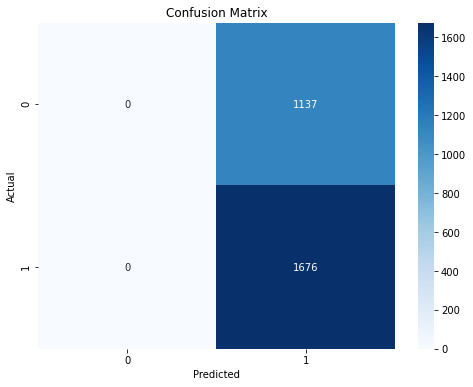

Precision: 0.5958051901884109
Recall: 1.0


In [61]:
# Расчет матрицы ошибок
conf_mat = confusion_matrix(y_test_t.numpy(), predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Расчет и вывод точности и полноты
precision = precision_score(y_test_t.numpy(), predictions)
recall = recall_score(y_test_t.numpy(), predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Вывод:

Модель не подходит, поскольку она будет абсолютно всегда выдавать предупреждение водителю.

### Проверяем работу другой модели, показавшей максимальный результат - дерева решений.

#### Воссоздаем параметры модели, обучаем и получаем предсказания.

In [62]:
dtc_model = DecisionTreeClassifier(random_state=SEED, criterion = 'gini', max_depth = 2)
dtc_model.fit(X_train_oe, y_train)
dtc_predictions = dtc_model.predict(X_test_oe)

#### Строим матрицу ошибок.

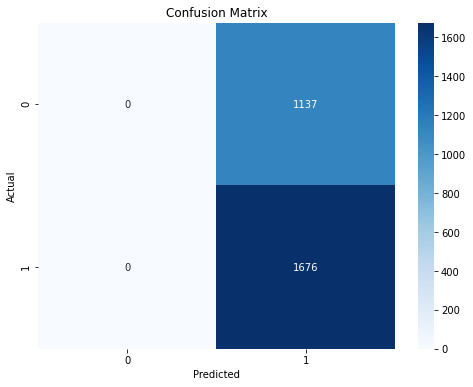

Precision: 0.5958051901884109
Recall: 1.0


In [63]:
# Расчет матрицы ошибок
conf_mat = confusion_matrix(y_test, dtc_predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Расчет и вывод точности и полноты
precision = precision_score(y_test, dtc_predictions)
recall = recall_score(y_test, dtc_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Вывод:

Модель не подходит, поскольку она будет абсолютно всегда выдавать предупреждение водителю.

### Проверяем работу другой модели, показавшей максимальный результат - случайного леса.

#### Воссоздаем параметры модели, обучаем и получаем предсказания.

In [64]:
rfc_model = RandomForestClassifier(random_state=SEED, max_depth = 1, n_estimators = 10)
rfc_model.fit(X_train_oe, y_train)
rfc_predictions = rfc_model.predict(X_test_oe)

#### Строим матрицу ошибок.

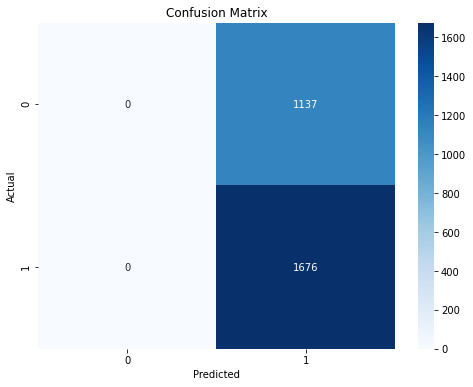

Precision: 0.5958051901884109
Recall: 1.0


In [65]:
# Расчет матрицы ошибок
conf_mat = confusion_matrix(y_test, rfc_predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Расчет и вывод точности и полноты
precision = precision_score(y_test, rfc_predictions)
recall = recall_score(y_test, rfc_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Вывод:

Модель не подходит, поскольку она будет абсолютно всегда выдавать предупреждение водителю.

### Проверяем работу другой модели, показавшей практически максимальный результат - логистической регрессии.

#### Воссоздаем параметры модели, обучаем и получаем предсказания.

In [67]:
lr_model = LogisticRegression(random_state=SEED, C=0.001, max_iter=1000)
lr_model.fit(X_train_ohe, y_train)
lr_predictions = lr_model.predict(X_test_ohe)

#### Строим матрицу ошибок.

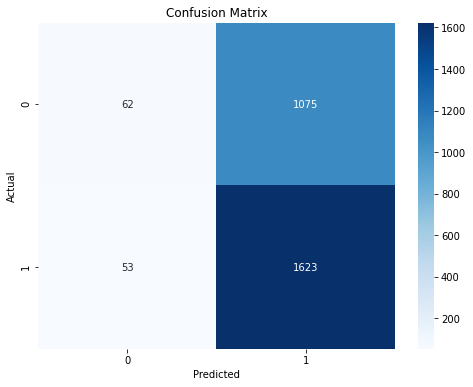

Precision: 0.6015567086730912
Recall: 0.9683770883054893


In [68]:
# Расчет матрицы ошибок
conf_mat = confusion_matrix(y_test, lr_predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Расчет и вывод точности и полноты
precision = precision_score(y_test, lr_predictions)
recall = recall_score(y_test, lr_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Вывод:

Модель не подходит, поскольку она будет почти всегда выдавать предупреждение водителю.

### Проверяем работу другой модели, показавшей следующий лучший результат - CatboostClassifier.

#### Воссоздаем параметры модели, обучаем и получаем предсказания.

In [70]:
cbc_model = CatBoostClassifier(random_state=SEED, verbose=False, cat_features=categorical_features, depth = 5, 
                               early_stopping_rounds=100, learning_rate=0.01)
cbc_model.fit(X_train, y_train)
cbc_predictions = cbc_model.predict(X_test)

#### Строим матрицу ошибок.

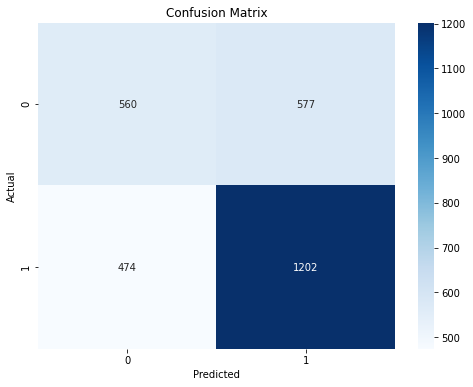

Precision: 0.6756604834176504
Recall: 0.7171837708830548


In [71]:
# Расчет матрицы ошибок
conf_mat = confusion_matrix(y_test, cbc_predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Расчет и вывод точности и полноты
precision = precision_score(y_test, cbc_predictions)
recall = recall_score(y_test, cbc_predictions)
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#### Вывод:

- Модель CatboostClassifier является наиболее адекватным решением, поскольку позволяет выявить чуть больше 2/3 виновников ДТП.
- Вместе с тем, метрики качества модели все равно оставляют желать лучшего (в случае ее внедрения ≈ на 2 верных предупреждения перед поездкой будет приходиться одно "ложное", при этом ≈ в 1/3 случаев необходимое предупреждение перед поездкой не возникнет).

### Анализируем важность признаков.

#### Строим график важности признаков.

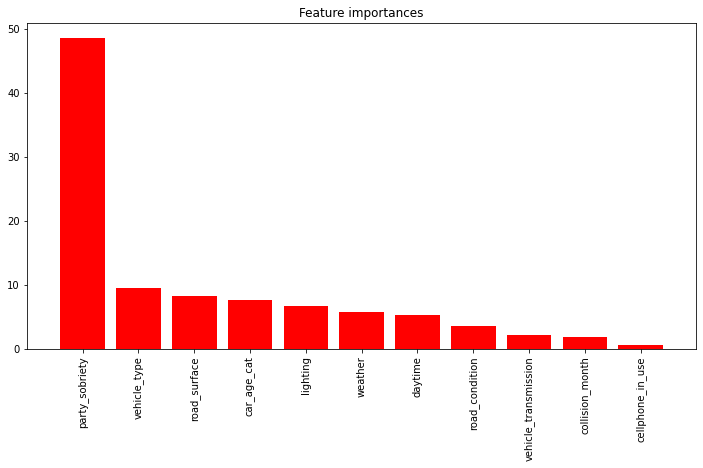

In [72]:
# Получаем важность признаков
importances = cbc_model.feature_importances_

# Получаем имена признаков
feature_names = X_test.columns

# Сортируем значения важности вместе с именами признаков
indices = np.argsort(importances)[::-1]
feature_names_sorted = [feature_names[i] for i in indices]

# Создаем график
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_test_oe.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_test_oe.shape[1]), feature_names_sorted, rotation='vertical')
plt.xlim([-1, X_test_oe.shape[1]])
plt.show()

**Про party sobriety уже все было написано в условии проекта, повторяться не буду. Поэтому рассмотрю полближе следующий по важности фактор.**

#### Исследуем детально признак vehicle_type.

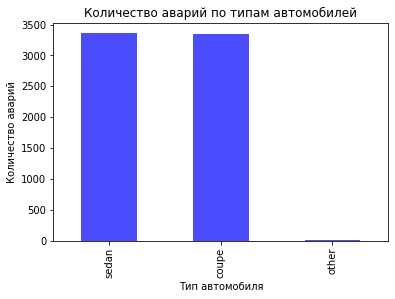

In [74]:
# Отфильтровываем данные, оставляем только строки, где 'at_fault' равно 1
fault_data = data[data['at_fault'] == 1]

# Считаем количество строк для каждого типа автомобиля
vehicle_counts = fault_data['vehicle_type'].value_counts()

# Создаем гистограмму
vehicle_counts.plot(kind='bar', color='b', alpha=0.7)

# Добавляем названия осей и заголовок графика
plt.xlabel('Тип автомобиля')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по типам автомобилей')
plt.show()

In [75]:
# изучаем распеределение данных по типам авто
data['vehicle_type'].value_counts()

sedan    6144
coupe    5104
other       2
Name: vehicle_type, dtype: int64

В таком разрезе признак не показателен. Посмотрим на среднее значение at_fault в зависимости от типа кузова.

In [76]:
# Группируем данные по 'vehicle_type' и рассчитываем среднее значение 'at_fault'
average_fault = data.groupby('vehicle_type')['at_fault'].mean()

print(average_fault)

vehicle_type
coupe    0.655760
other    1.000000
sedan    0.546061
Name: at_fault, dtype: float64


#### Вывод по итогам анализа признака vehicle_type.

Водители автомобилей с типом кузова купе существенно чаще попадают в ДТП, чем водители седанов.

#### Предложения для каршеринговой компании:

- Автомобили класса купе, как правило, привлекают более рисковых и менее опытных водителей. Одним из решений будет ограничение парка таких автомобилей в целях предотвращения убытков.
- Оставить в парке только высокотехнологичные автомобили такого класса, в которых зеркала и камеры обеспечивают идеальный обзор, а автоматика предотвращает и/или минимизирует опасное вождение водителя.

## Выводы

- Модель CatboostClassifier на данный момент является наиболее адекватным решением, поскольку позволяет выявить чуть больше 2/3 виновников ДТП.
- Вместе с тем, метрики качества модели все равно оставляют желать лучшего (в случае ее внедрения ≈ на 2 верных предупреждения перед поездкой будет приходиться одно "ложное", при этом ≈ в 1/3 случаев необходимое предупреждение перед поездкой не возникнет).
- Полагаю, что в настоящий момент создать модель, которая бы выявляла подавляющее большинство потенциальных виновников ДТП и при этом не давала бы значительное количество ложно-положительных ответов, представляется затруднительным. Данных для этого недостаточно.
- Для создания такой модели необходимы дополнительные данные, например:
  - данные о предыдущих ДТП с участием этого водителя (полагаю, что такая информация должна быть доступна для каршеринговых компаний);
  - данные об опасных участках маршрута, который собирается преодолеть водитель (на основании сведений о частоте ДТП на соответствующем участке);
  - данные о предыдущем вождении в уставшем состоянии - в идеале машины должны быть оборудованы устройствами для контроля усталости, каждый случай вождения в таком состоянии должен фиксироваться в истории водителя, которая должна формироваться централизованно и быть доступна для всех каршеринговых компаний на основании лицензии.